In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.info import getinfo
import sigpy.mri as mr
from Utils.GenMask import gen_mask
from Utils.Transform import fourier_transform, inverse_fourier_transform
from Utils.Normalize_complex_data import normalize_complex_data

## **Simulation of the data undersampling**

In [3]:
kspace, image = getinfo()
image = image[22]
ksp = kspace[22]
mask = gen_mask(ksp,num_lines=186, num_central_lines=0)
mask_2 = gen_mask(ksp,num_lines=156, num_central_lines=30)
s = ksp * mask # Data adquired for the MRI
s_2 = ksp * mask_2

In [4]:
s_normalized = normalize_complex_data(s)
s_2_normalized = normalize_complex_data(s_2)
x_normalized = inverse_fourier_transform(s_normalized)
x_2_normalized = inverse_fourier_transform(s_2_normalized)

print("Max of |s_normalized|:", np.max(np.abs(s_normalized)))
print("Max of |x_normalized|:", np.max(np.abs(x_normalized)))
print("Max of |s_2_normalized|:", np.max(np.abs(s_2_normalized)))
print("Max of |x_2_normalized|:", np.max(np.abs(x_2_normalized)))

Max of |s_normalized|: 1.0
Max of |x_normalized|: 0.039002351279560914
Max of |s_2_normalized|: 1.0
Max of |x_2_normalized|: 0.07064358956841812


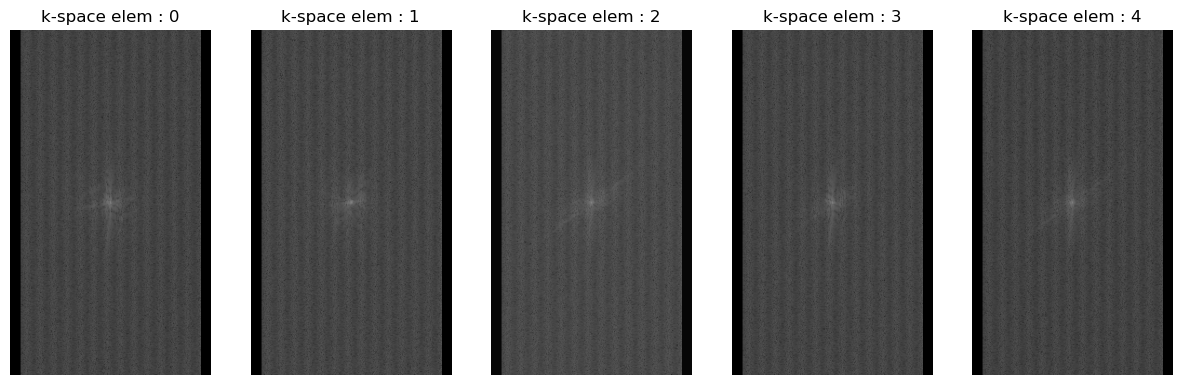

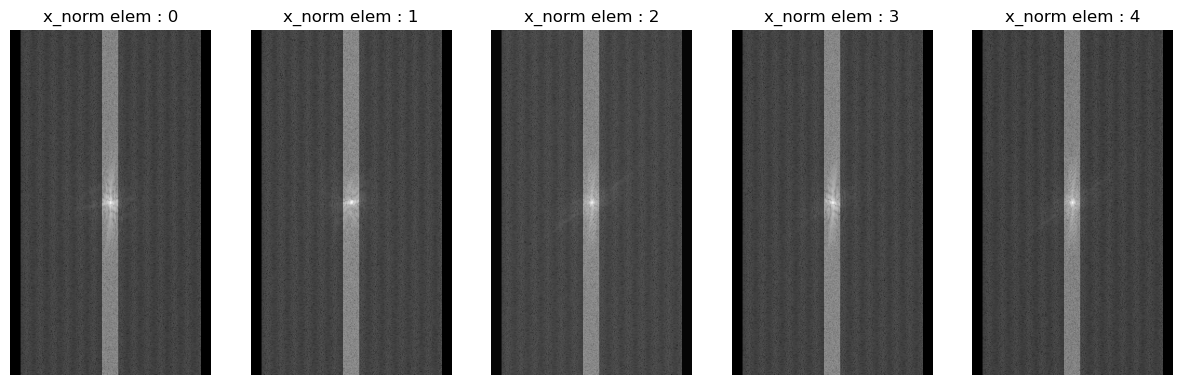

In [5]:
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.log(np.abs(s_normalized[i])+1e-12), cmap='gray')
    plt.title(f'k-space elem : {i}')
    plt.axis('off')
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.log(np.abs(s_2_normalized[i])+1e-12), cmap='gray')
    plt.title(f'x_norm elem : {i}')
    plt.axis('off')

In [6]:
# Sensibility maps, usign ESPIRiT
Cs = mr.app.EspiritCalib(s).run()
Cs_2 = mr.app.EspiritCalib(s_2).run()

sensitivities_normalized_cs = Cs / np.sqrt(np.sum(np.abs(Cs)**2, axis=0, keepdims=True) + 1e-8)
np.save('./Data/sensitivities_normalized_cs.npy', sensitivities_normalized_cs)
sensitivities_normalized_cs_2 = Cs_2 / np.sqrt(np.sum(np.abs(Cs_2)**2, axis=0, keepdims=True) + 1e-8)
np.save('./Data/sensitivities_normalized_cs_2.npy', sensitivities_normalized_cs_2)

print("Max of |sensitivities_normalized_cs| (coil normalization per sensitivities_normalized_cs):", np.max(np.sum(np.abs(sensitivities_normalized_cs) ** 2, axis=0)))
print("Max of |sensitivities_normalized_ksp| (coil normalization per sensitivities_normalized_ksp):", np.max(np.sum(np.abs(sensitivities_normalized_cs_2) ** 2, axis=0)))

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

Max of |sensitivities_normalized_cs| (coil normalization per sensitivities_normalized_cs): 1.0000005
Max of |sensitivities_normalized_ksp| (coil normalization per sensitivities_normalized_ksp): 1.0000005


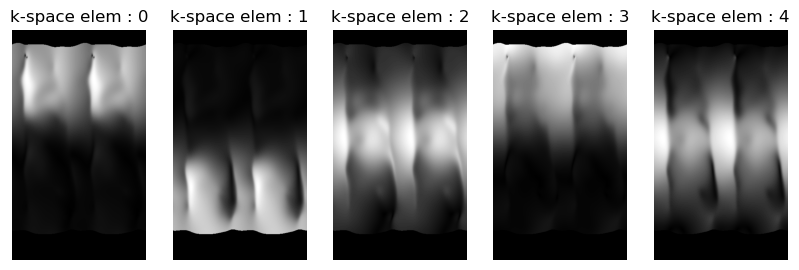

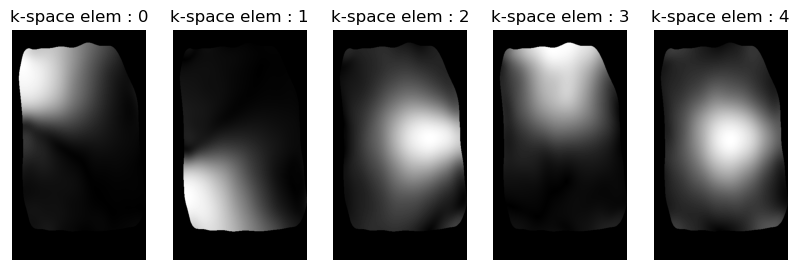

In [7]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(sensitivities_normalized_cs[i]), cmap='gray')
    plt.title(f'k-space elem : {i}')
    plt.axis('off')
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(sensitivities_normalized_cs_2[i]), cmap='gray')
    plt.title(f'k-space elem : {i}')
    plt.axis('off')

In [8]:
def grad(x, s, mask, Cs, lmda=0.1):
    #Compute the gradient of the loss function: L(x) = ||s - E(x)||^2 + lambda * ||x||^2
    # grad(L(x)) = -2 * E_H(s - E(x)) + 2 * lambda * x
    
    # Step 1: Compute E(x)
    C_x = x * Cs
    CF_x = fourier_transform(C_x)
    E_x = mask * CF_x
    
    # Step 2: Compute s - E(x)
    residual = s - E_x
    
    # Step 3: Compute E_H(s - E(x))
    F1residual = inverse_fourier_transform(mask * residual)
    grad_x = -2 * Cs.conj() * F1residual
    
    # Step 4: Add regularization term
    grad_x = grad_x + 2 * lmda * x
    
    return grad_x

def loss(x, s, mask, Cs, lmda=0.1):
    
    # Compute E(x) for a given image
    C_x = x * Cs
    CF_x = fourier_transform(C_x)
    E_x = mask * CF_x
    
    # Compute loss: 1/2 * ||s - E(x)||^2 + lambda * ||x||^2
    data_fidelity = np.sum(np.abs(s - E_x) ** 2) / 2
    regularization = lmda * np.sum(np.abs(x) ** 2)
    total_loss = data_fidelity + regularization

    return total_loss

def GD(s, mask, Cs, lr=0.01, epochs=10, lmda=0.1):
    
    #Initialize x as a complex matrix
    x = np.zeros(s.shape, dtype=np.complex128)
    
    lista_loss = []
    for i in range(epochs):
        # Compute gradient
        gradiente = grad(x, s, mask, Cs, lmda)
        
        # Update x
        x = x - lr * gradiente
        
        # Compute loss
        losses = loss(x, s, mask, Cs, lmda)
        lista_loss.append(losses)
        
        # Print loss
        if i%5 == 0 :
            print(f"Epoch: {i}, Loss: {lista_loss[-1]}")
    
    return x, lista_loss

In [9]:
x_cs, lista_loss_cs = GD(s_normalized, mask, sensitivities_normalized_cs, lmda = 0.1, lr=0.1, epochs=25)       # bad sensitivity maps
x_cs_2, lista_loss_cs_2 = GD(s_2_normalized, mask, sensitivities_normalized_cs_2, lmda=0.1, lr=0.1, epochs=25) # good sensitivity maps
x_cs_3, lista_loss_cs_3 = GD(s_2_normalized, mask, sensitivities_normalized_cs_2, lmda=100, lr=0.1, epochs=25) # lambda big

Epoch: 0, Loss: 19.17892524659991
Epoch: 5, Loss: 17.624067022667187
Epoch: 10, Loss: 16.85067329149664
Epoch: 15, Loss: 16.47158146335789
Epoch: 20, Loss: 16.30301957598415
Epoch: 0, Loss: 30.9780942858587
Epoch: 5, Loss: 29.590421975879167
Epoch: 10, Loss: 28.8684722836362
Epoch: 15, Loss: 28.504298426354886
Epoch: 20, Loss: 28.337512661703766
Epoch: 0, Loss: 39.338485917874856
Epoch: 5, Loss: 47171132715334.47
Epoch: 10, Loss: 2.9435026922143163e+26
Epoch: 15, Loss: 1.8369957453801347e+39
Epoch: 20, Loss: 1.1465885734037193e+52


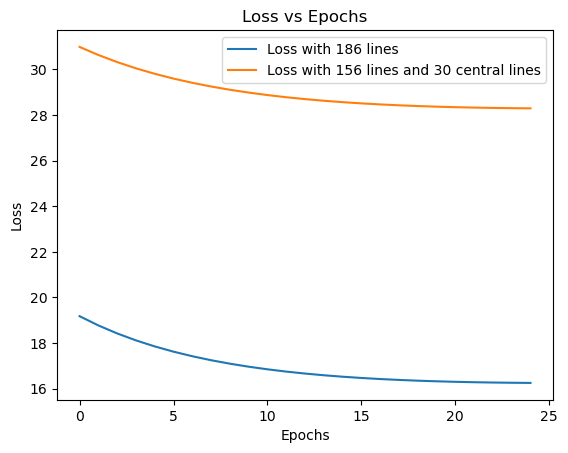

In [10]:
plt.plot(lista_loss_cs, label='Loss with 186 lines')
plt.plot(lista_loss_cs_2, label='Loss with 156 lines and 30 central lines')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

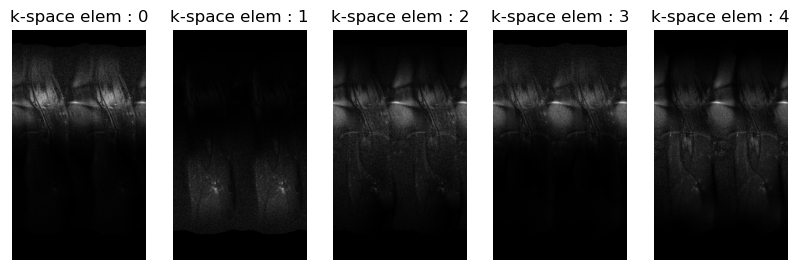

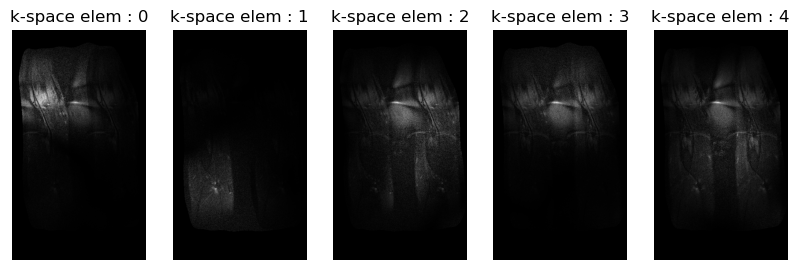

In [11]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(x_cs[i]), cmap='gray')
    plt.title(f'k-space elem : {i}')
    plt.axis('off')
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(x_cs_2[i]), cmap='gray')
    plt.title(f'k-space elem : {i}')
    plt.axis('off')

In [12]:
img_sense = mr.app.SenseRecon(s, sensitivities_normalized_cs, lamda=0.1).run()  # bad sensitivity maps
img_sense_2 = mr.app.SenseRecon(s_2, sensitivities_normalized_cs_2, lamda=0.1).run()    # good sensitivity maps
img_sense_3 = mr.app.SenseRecon(s_2, sensitivities_normalized_cs_2, lamda=100).run()    # lambda big

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

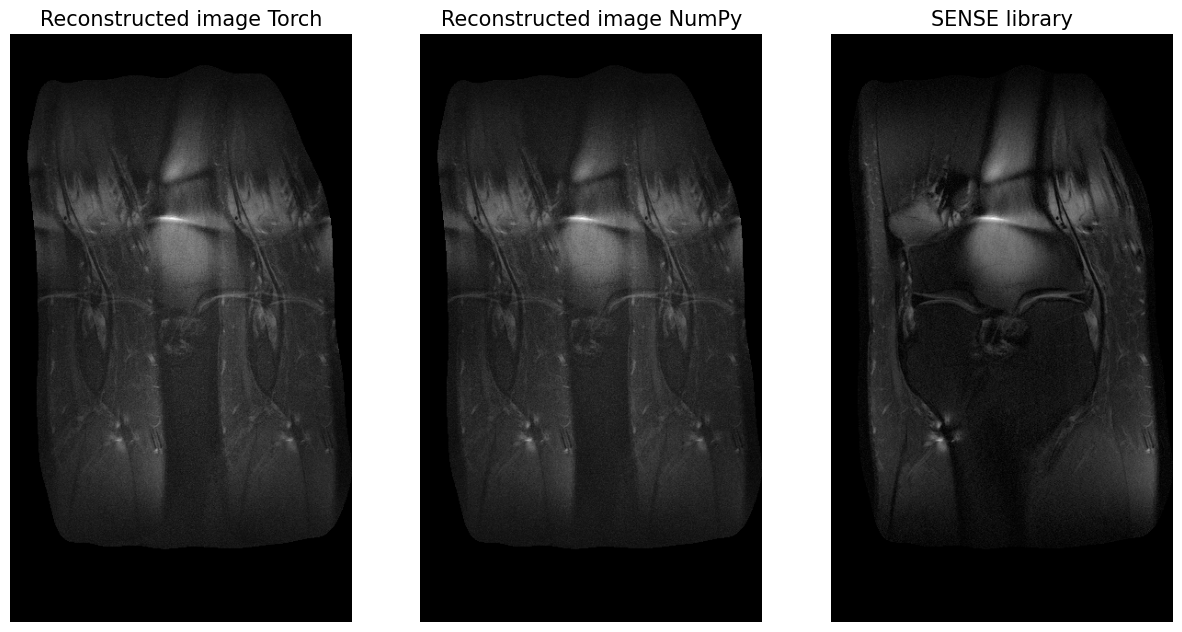

In [13]:
img_recon = np.sum(np.abs(x_cs), axis=0)
img_recon2 = np.sum(np.abs(x_cs_2), axis=0)


img_Torch = np.load('./Data/img_recon_cs_2.npy')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(np.log(img_Torch + 1e-1), cmap='gray')
plt.axis('off')
plt.title(f'Reconstructed image Torch', fontsize=15)
plt.subplot(1, 3, 2)
plt.imshow(np.log(img_recon2 + 1e-1), cmap='gray')
plt.axis('off')
plt.title(f'Reconstructed image NumPy', fontsize=15)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(img_sense_2) + 1e-4), cmap='gray')
plt.axis('off')
plt.title('SENSE library', fontsize=15)
plt.show()